In [ ]:
# Importation of useful libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation


from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")
plt.style.use('bmh')


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/PDS Project/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [ ]:
nan_rows = data[data.isnull().T.any().T]
nan_rows.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
data[data['InvoiceNo']== '536414']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom


In [ ]:
data[data['InvoiceNo']== '536544'][:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
data = data.dropna(subset=["CustomerID"])

Text(0.5, 1.0, 'Ratio of missing values per columns')

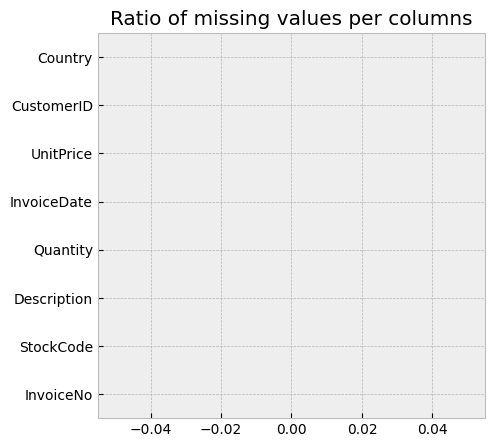

In [ ]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [ ]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 5225


In [ ]:
customer_country=data[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


In [ ]:
data.describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [ ]:
data[(data['Quantity']<0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


In [ ]:
# Constucting a basket for later use
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [ ]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

In [ ]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1][:5]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [ ]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom


In [ ]:
test = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Our initial hypothesis is wrong')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [ ]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,12/5/2010 13:17,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/5/2010 13:17,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,12/5/2010 13:17,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,12/5/2010 13:17,3.95,14527,United Kingdom


In [ ]:
data_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('The second hypothesis is also wrong')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
The second hypothesis is also wrong


In [ ]:
data[(data['CustomerID'] == '15311') & (data['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/5/2010 13:55,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/8/2010 13:18,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,12/13/2010 15:07,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,12/20/2010 15:27,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/5/2011 11:41,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,1/17/2011 13:39,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2/1/2011 12:14,4.65,15311,United Kingdom


check............................

In [ ]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6151
doubtfull_entry: 2607


In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0


In [ ]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)


In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

In [ ]:
df_cleaned.describe()


,Quantity,UnitPrice,QuantityCanceled
count,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,0.583911
std,181.907403,4.284639,175.868790
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,0.000000
50%,6.000000,1.950000,0.000000
75%,12.000000,3.750000,0.000000
max,80995.000000,649.500000,80995.000000


In [ ]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081,United Kingdom,0


In [ ]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18405
StockCode :  3659
Description :  3871
Quantity :  300
InvoiceDate :  17169
UnitPrice :  356
CustomerID :  4335
Country :  37
QuantityCanceled :  115


In [ ]:
# Total price feature

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

Text(0.5, 1.0, 'Revenue per Country')

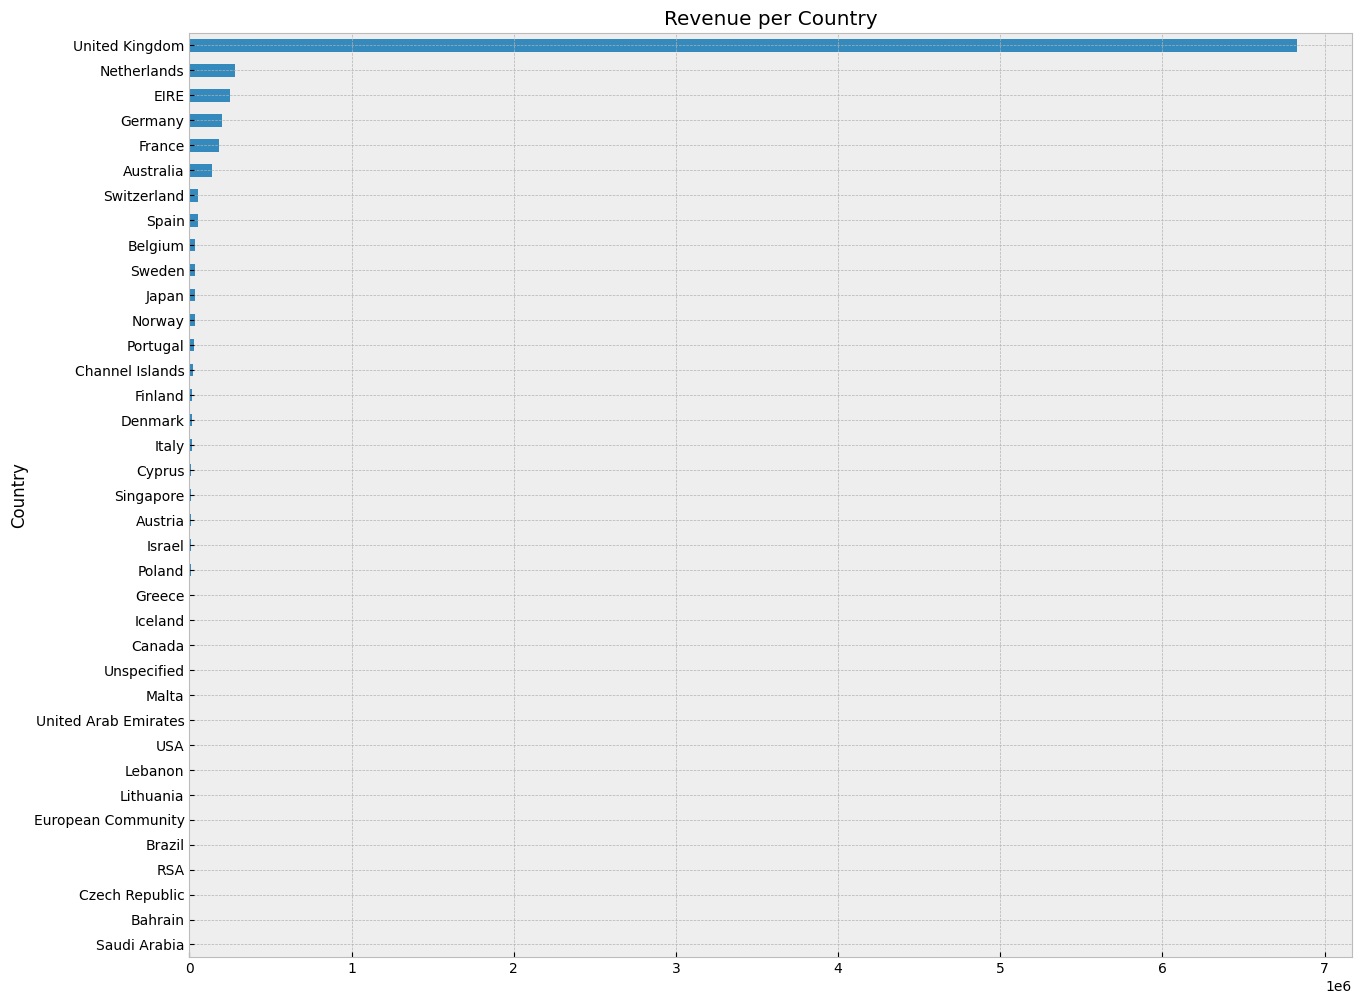

In [ ]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")

Text(0.5, 1.0, 'Number of Invoices per Country')

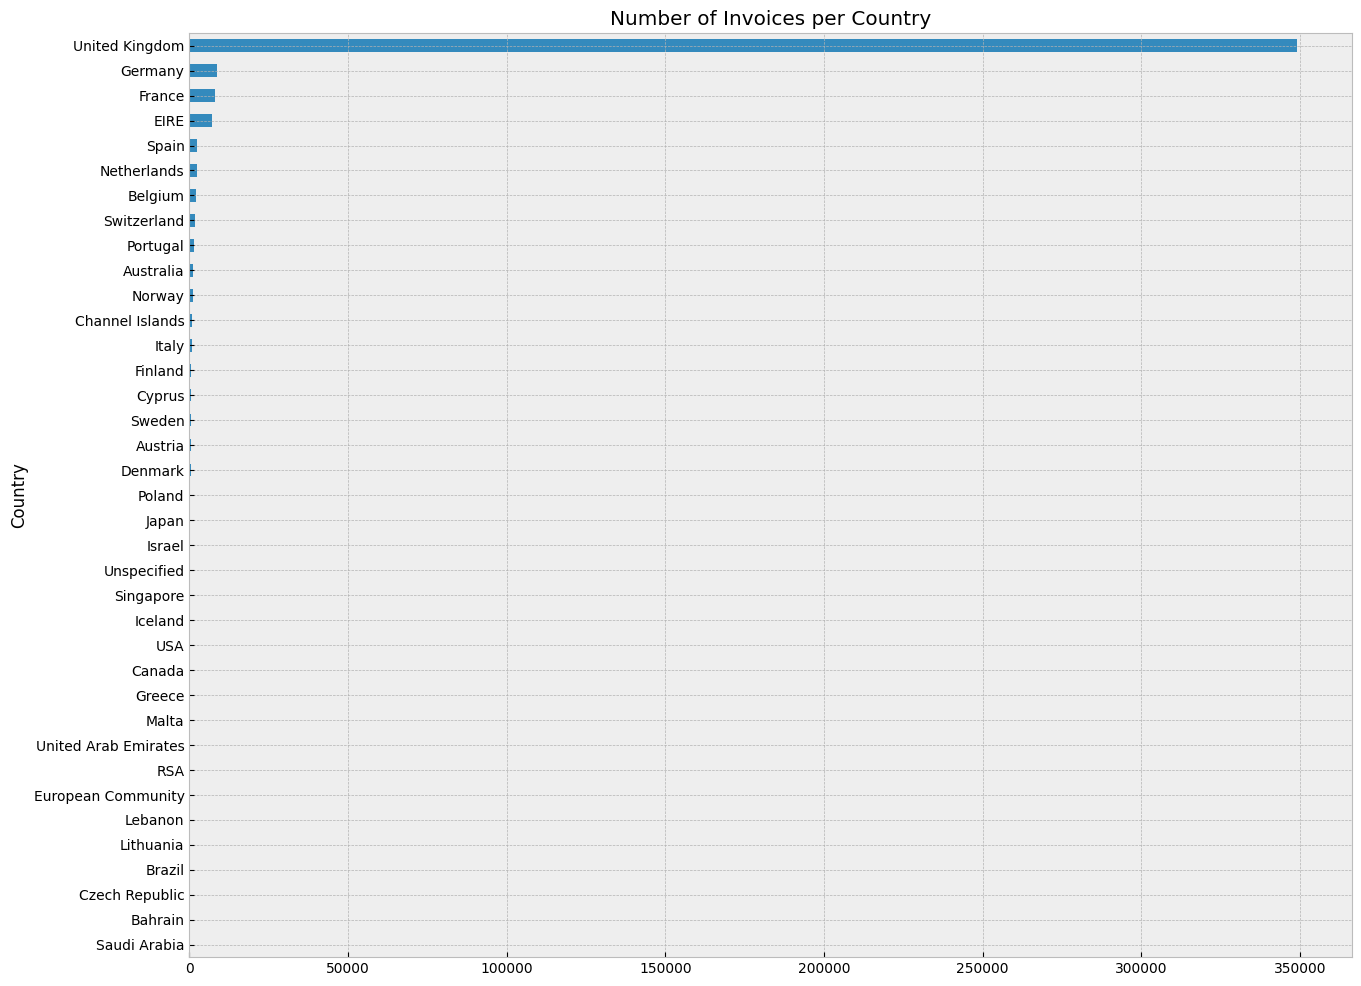

In [ ]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")

In [ ]:
le = LabelEncoder()
le.fit(df_cleaned['Country'])

LabelEncoder()

In [ ]:
l = [i for i in range(37)]
dict(zip(list(le.classes_), l))

{'Australia': 0,
 'Austria': 1,
 'Bahrain': 2,
 'Belgium': 3,
 'Brazil': 4,
 'Canada': 5,
 'Channel Islands': 6,
 'Cyprus': 7,
 'Czech Republic': 8,
 'Denmark': 9,
 'EIRE': 10,
 'European Community': 11,
 'Finland': 12,
 'France': 13,
 'Germany': 14,
 'Greece': 15,
 'Iceland': 16,
 'Israel': 17,
 'Italy': 18,
 'Japan': 19,
 'Lebanon': 20,
 'Lithuania': 21,
 'Malta': 22,
 'Netherlands': 23,
 'Norway': 24,
 'Poland': 25,
 'Portugal': 26,
 'RSA': 27,
 'Saudi Arabia': 28,
 'Singapore': 29,
 'Spain': 30,
 'Sweden': 31,
 'Switzerland': 32,
 'USA': 33,
 'United Arab Emirates': 34,
 'United Kingdom': 35,
 'Unspecified': 36}

In [ ]:
df_cleaned['Country'] = le.transform(df_cleaned['Country'])

In [ ]:
with open('labelencoder.pickle', 'wb') as g:
    pickle.dump(le, g)

In [ ]:
df_cleaned.head(5)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,35,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,35,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,35,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,35,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,35,0,20.34


In [ ]:
df_cleaned['InvoiceDate'].min()

'1/10/2011 10:32'

In [ ]:
df_cleaned['InvoiceDate'].max()

'9/9/2011 9:52'

In [ ]:
# I'll just fix the date to be one day after the last entry in the databse

NOW = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [ ]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"


rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [ ]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")


In [ ]:
rfmTable.head(5)

,InvoiceDate,CustomerID,TotalPrice,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850,139.12,373.0
536366,2010-12-01 08:28:00,17850,22.20,373.0
536367,2010-12-01 08:34:00,13047,278.73,373.0
536368,2010-12-01 08:34:00,13047,70.05,373.0
536369,2010-12-01 08:35:00,13047,17.85,373.0


In [ ]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [ ]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12346,325.0,325.0,1,0.00
12347,2.0,367.0,7,4310.00
12348,75.0,358.0,4,1437.24
12349,18.0,18.0,1,1457.55
12350,310.0,310.0,1,294.40


In [ ]:
first_customer = df_cleaned[df_cleaned['CustomerID']=='12747']
first_customer.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,35,0,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,35,0,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,35,0,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,35,0,39.60
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,35,0,32.70


In [ ]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
segmented_rfm = rfmTable_final

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12347,2.0,367.0,7,4310.00,1,1,1
12348,75.0,358.0,4,1437.24,3,2,2
12349,18.0,18.0,1,1457.55,2,4,2
12350,310.0,310.0,1,294.40,4,4,4


In [ ]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12347,2.0,367.0,7,4310.00,1,1,1
12348,75.0,358.0,4,1437.24,3,2,2
12349,18.0,18.0,1,1457.55,2,4,2
12350,310.0,310.0,1,294.40,4,4,4


In [ ]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()


,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [ ]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
14646,1.0,354.0,73,278742.02,1,1,1,111
18102,0.0,367.0,60,259657.30,1,1,1,111
17450,8.0,367.0,46,193417.63,1,1,1,111
14911,1.0,373.0,198,131009.71,1,1,1,111
14156,9.0,371.0,54,113728.45,1,1,1,111
...,...,...,...,...,...,...,...,...
12528,9.0,312.0,6,1640.48,1,1,1,111
15024,9.0,367.0,10,1636.43,1,1,1,111
12423,0.0,353.0,8,1624.11,1,1,1,111


In [ ]:
segmented_rfm.head(5)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12347,2.0,367.0,7,4310.00,1,1,1,111
12348,75.0,358.0,4,1437.24,3,2,2,322
12349,18.0,18.0,1,1457.55,2,4,2,242
12350,310.0,310.0,1,294.40,4,4,4,444


In [ ]:
segmented_rfm = segmented_rfm.reset_index()

In [ ]:
segmented_rfm.head(5)

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,325.0,325.0,1,0.00,4,4,4,444
1,12347,2.0,367.0,7,4310.00,1,1,1,111
2,12348,75.0,358.0,4,1437.24,3,2,2,322
3,12349,18.0,18.0,1,1457.55,2,4,2,242
4,12350,310.0,310.0,1,294.40,4,4,4,444


In [ ]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='CustomerID')

In [ ]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

In [ ]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

In [ ]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)

In [ ]:
df_cleaned['Month'].value_counts()

11    62949
10    48613
12    42536
9     39510
5     27962
6     26820
3     26752
8     26688
7     26476
4     22347
1     20899
2     19631
Name: Month, dtype: int64

In [ ]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [ ]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,35,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,35,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,35,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3871, 1694) of float64


In [ ]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3871, 1694) of float64


In [ ]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3871, 100) of float64


In [ ]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

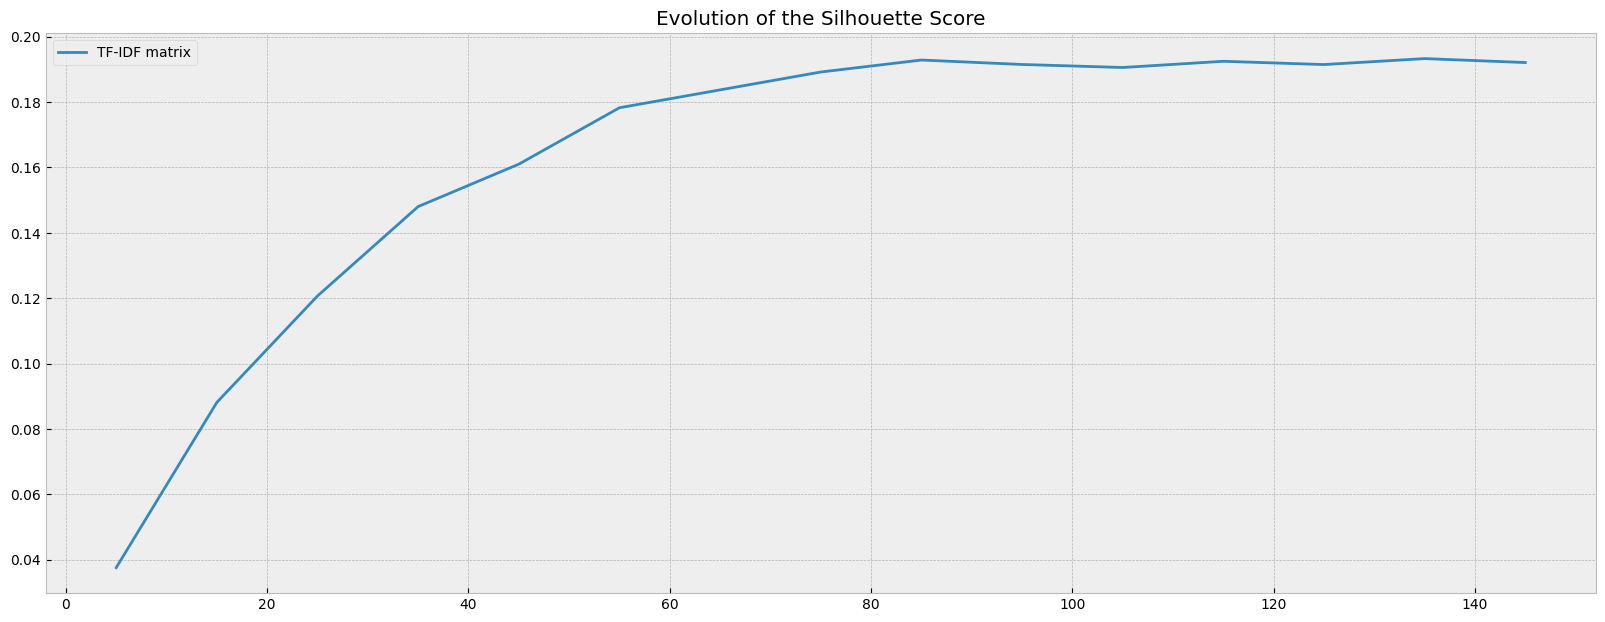

In [ ]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

Text(0.5, 1.0, 'ACP with 135 clusters')

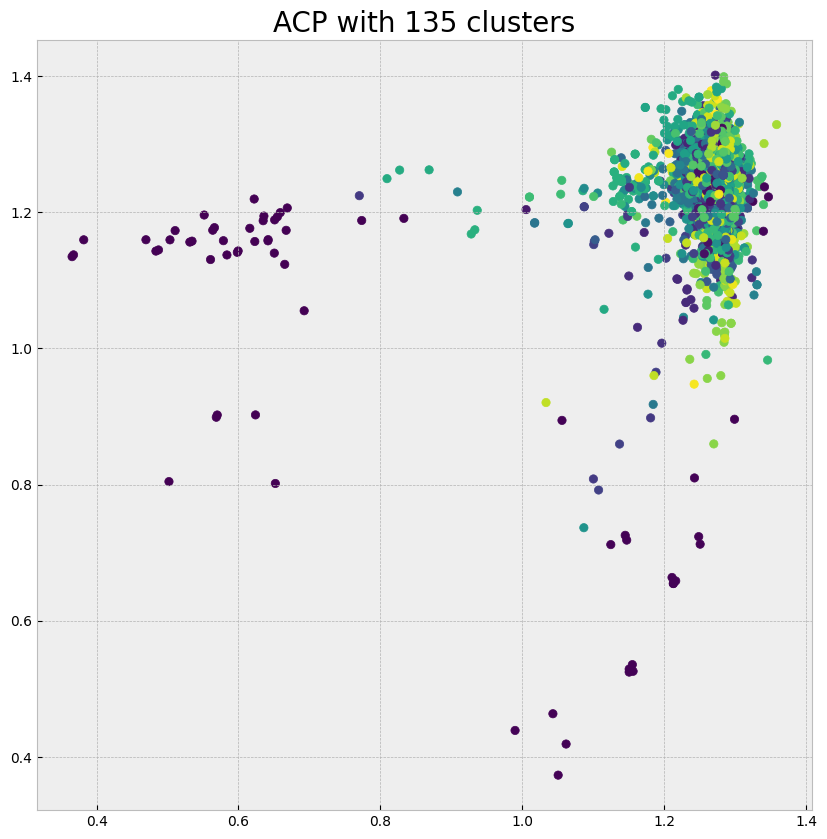

In [ ]:
n_clusters = 135

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 135 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

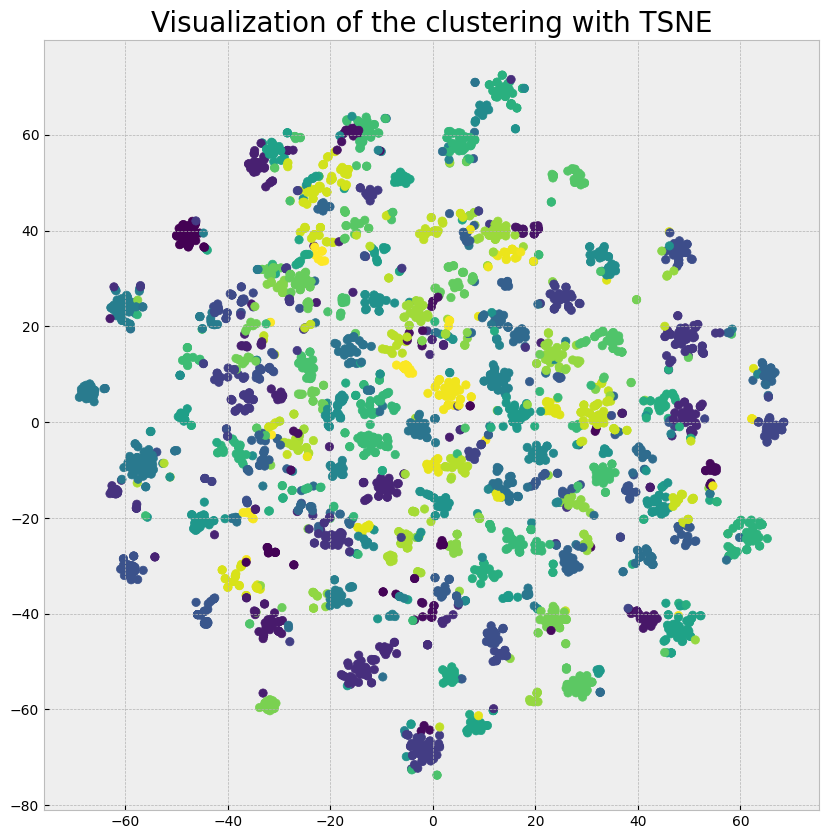

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

<Figure size 640x480 with 0 Axes>

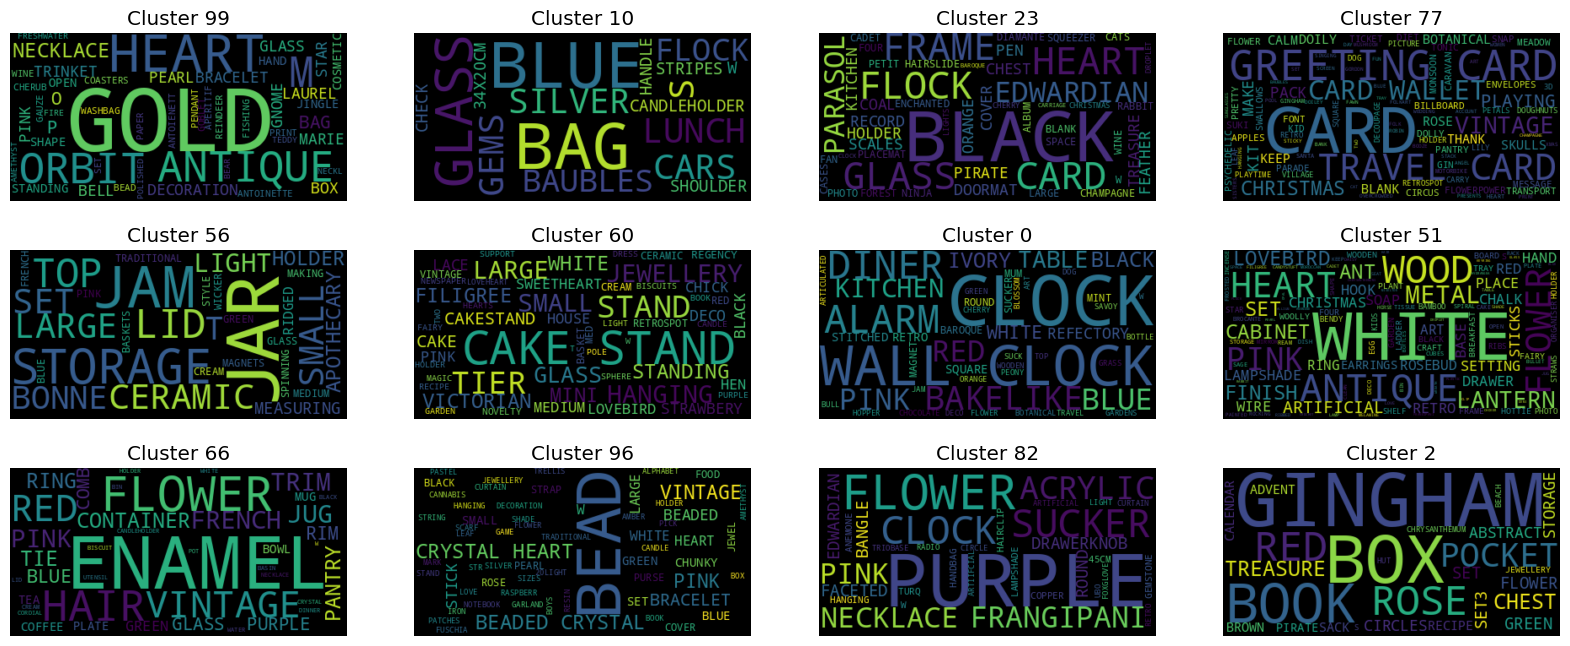

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

<Axes: >

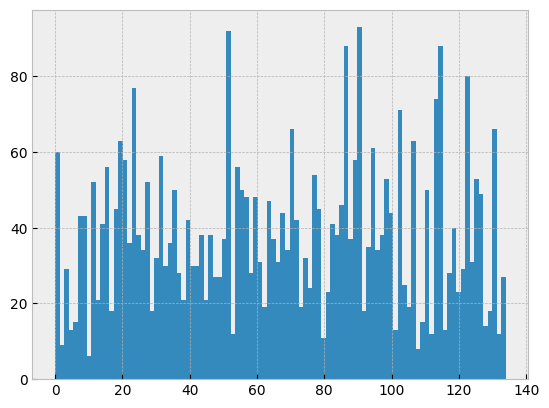

In [ ]:
pd.Series(clusters).hist(bins=100)

In [ ]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

In [ ]:
with open('product_clusters.pickle', 'wb') as h:
    pickle.dump(dict_article_to_cluster, h)

In [ ]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [ ]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [ ]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [ ]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
df_grouped_final.head(5)

TotalPrice                   min_recency max_recency frequency  \
                  min    max       mean    <lambda>    <lambda>  <lambda>   
CustomerID                                                                  
12346             0.0    0.0   0.000000       325.0       325.0         1   
12347            13.2   45.0  23.308571         2.0       367.0         7   
12348            39.6  150.0  82.840000        75.0       358.0         4   
12349            15.0   15.0  15.000000        18.0        18.0         1   
12350            25.2   25.2  25.200000       310.0       310.0         1   

           monetary_value Quantity  Country  
                 <lambda>      sum <lambda>  
CustomerID                                   
12346                0.00    74215       35  
12347             4310.00     2458       16  
12348             1437.24     2332       12  
12349             1457.55      630       18  
12350              294.40      196       24

In [ ]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [ ]:
df_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country
CustomerID,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24


In [ ]:
df2_grouped_final.head(5)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
12347,0.106218,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.017374,0.002900,0.0,0.0,0.0,0.009234,0.000000,0.0,0.0
12348,0.000000,0.0,0.0,0.121065,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
12349,0.000000,0.0,0.0,0.017083,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.024939,0.086282,0.0,0.0,0.0,0.040465,0.006998,0.0,0.0
12350,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
X1 = df_grouped_final.values
X2 = df2_grouped_final.values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)


In [ ]:

x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.8857140401345782 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8739460186348265 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.2539665263711213 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.3412106964580916 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.3885535255567511 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.39822925607705734 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.4061231139240791 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.41010174993664417 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.40905508487957365 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.40822825026072507 with Std Scaling


In [ ]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

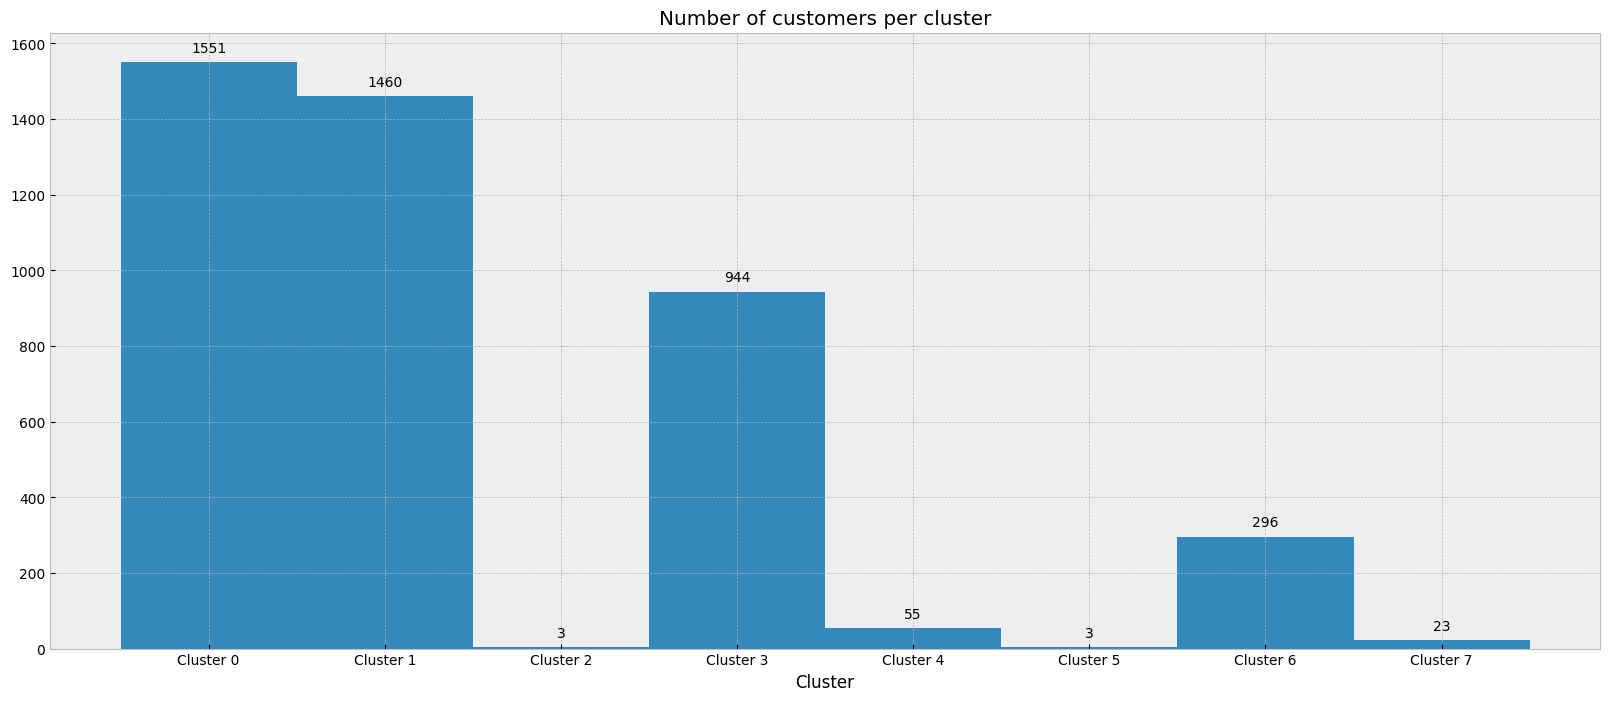

In [ ]:

plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)


In [ ]:
df_grouped_final["cluster"] = clusters

In [ ]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.head()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.000000,325.0,325.0,1,0.00,74215,35,7,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
12347,13.2,45.0,23.308571,2.0,367.0,7,4310.00,2458,16,6,...,0.0,0.017374,0.002900,0.0,0.0,0.0,0.009234,0.000000,0.0,0.0
12348,39.6,150.0,82.840000,75.0,358.0,4,1437.24,2332,12,6,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
12349,15.0,15.0,15.000000,18.0,18.0,1,1457.55,630,18,6,...,0.0,0.024939,0.086282,0.0,0.0,0.0,0.040465,0.006998,0.0,0.0
12350,25.2,25.2,25.200000,310.0,310.0,1,294.40,196,24,3,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
final_dataset_V2 = final_dataset.reset_index()

In [ ]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

In [ ]:
with open('df_cleaned.pickle', 'wb') as f:
    pickle.dump(df_cleaned, f)

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

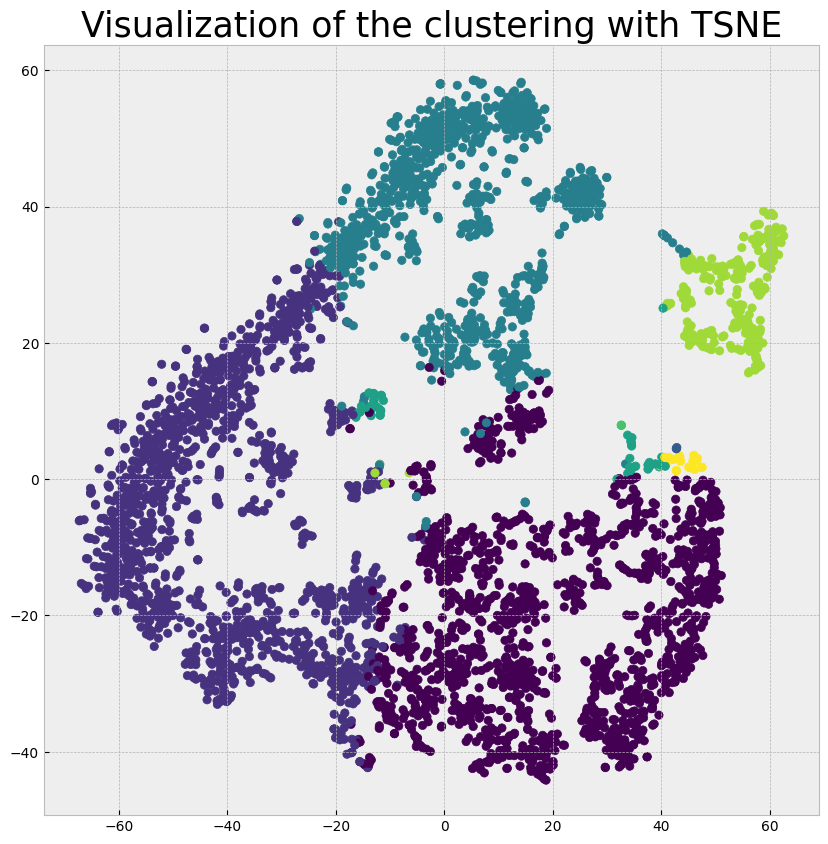

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

In [ ]:
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,country,cluster,...,Cluster_125,Cluster_126,Cluster_127,Cluster_128,Cluster_129,Cluster_130,Cluster_131,Cluster_132,Cluster_133,Cluster_134
CustomerID,,,,,,,,,,,,,,,,,,,,,
12352,0.00,35.70,16.842857,36.0,296.0,7,1265.41,526,24,0,...,0.0,0.059032,0.039734,0.031294,0.040303,0.000000,0.009878,0.00000,0.000000,0.011854
12356,25.50,102.00,51.300000,22.0,325.0,3,2487.43,1573,26,0,...,0.0,0.000000,0.088316,0.000000,0.000000,0.030152,0.000000,0.00000,0.000000,0.000000
12363,15.90,69.36,42.630000,109.0,242.0,2,552.00,408,36,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.217391,0.000000,0.00000,0.000000,0.000000
12409,0.00,79.20,47.200000,78.0,182.0,3,11056.93,5551,32,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.016279,0.022791,0.00000,0.000000,0.000000
12421,9.90,30.00,18.225000,15.0,319.0,4,639.04,478,30,0,...,0.0,0.000000,0.152103,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18263,15.00,30.60,21.920000,25.0,252.0,3,1211.08,1468,35,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
18270,19.80,33.20,26.500000,38.0,266.0,2,244.90,101,35,0,...,0.0,0.080849,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.488363,0.061249
18272,6.64,18.72,13.053333,2.0,246.0,6,3063.98,2050,35,0,...,0.0,0.052726,0.000000,0.000000,0.000000,0.000000,0.007180,0.00000,0.000000,0.000000


In [ ]:
final_dataset[final_dataset['cluster']==0].mean()


min             10.373488
max             71.196802
mean            31.186975
min_recency     36.564797
max_recency    312.156673
                  ...    
Cluster_130      0.003694
Cluster_131      0.006961
Cluster_132      0.001172
Cluster_133      0.004350
Cluster_134      0.009646
Length: 145, dtype: float64

In [ ]:
temp_final_df = final_dataset.reset_index()

In [ ]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [ ]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity              10.268091
UnitPrice              2.899498
QuantityCanceled       0.128702
TotalPrice            17.437493
frequency             11.192367
min_recency           24.465389
monetary_value      5547.580530
dtype: float64

In [ ]:
cluster0['Description'].value_counts()[:10]

WHITE HANGING HEART T-LIGHT HOLDER    1349
JUMBO BAG RED RETROSPOT               1089
REGENCY CAKESTAND 3 TIER               977
PARTY BUNTING                          932
ASSORTED COLOUR BIRD ORNAMENT          928
LUNCH BAG RED RETROSPOT                902
LUNCH BAG  BLACK SKULL.                754
SET OF 3 CAKE TINS PANTRY DESIGN       729
LUNCH BAG CARS BLUE                    679
LUNCH BAG PINK POLKADOT                678
Name: Description, dtype: int64

In [ ]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
cluster0_grouped['RFMScore'].value_counts()

111    363
211    156
322    122
222    118
122     97
321     81
221     67
311     60
121     48
112     47
323     44
212     42
223     42
333     39
332     37
233     31
312     22
123     21
133     20
334     18
232     18
234     15
132      7
134      6
231      5
324      4
113      3
224      3
411      2
213      2
412      2
124      2
331      2
422      1
424      1
433      1
313      1
114      1
Name: RFMScore, dtype: int64

In [ ]:
cluster0_grouped['Country'].value_counts()

35    1515
30      13
32       7
26       6
24       2
31       2
25       2
23       2
36       1
29       1
Name: Country, dtype: int64

In [ ]:
cluster0['Month'].value_counts()


11    33255
12    25907
10    24720
9     22546
5     18311
3     18139
8     16751
6     16085
7     15823
4     15762
1     13992
2     13126
Name: Month, dtype: int64

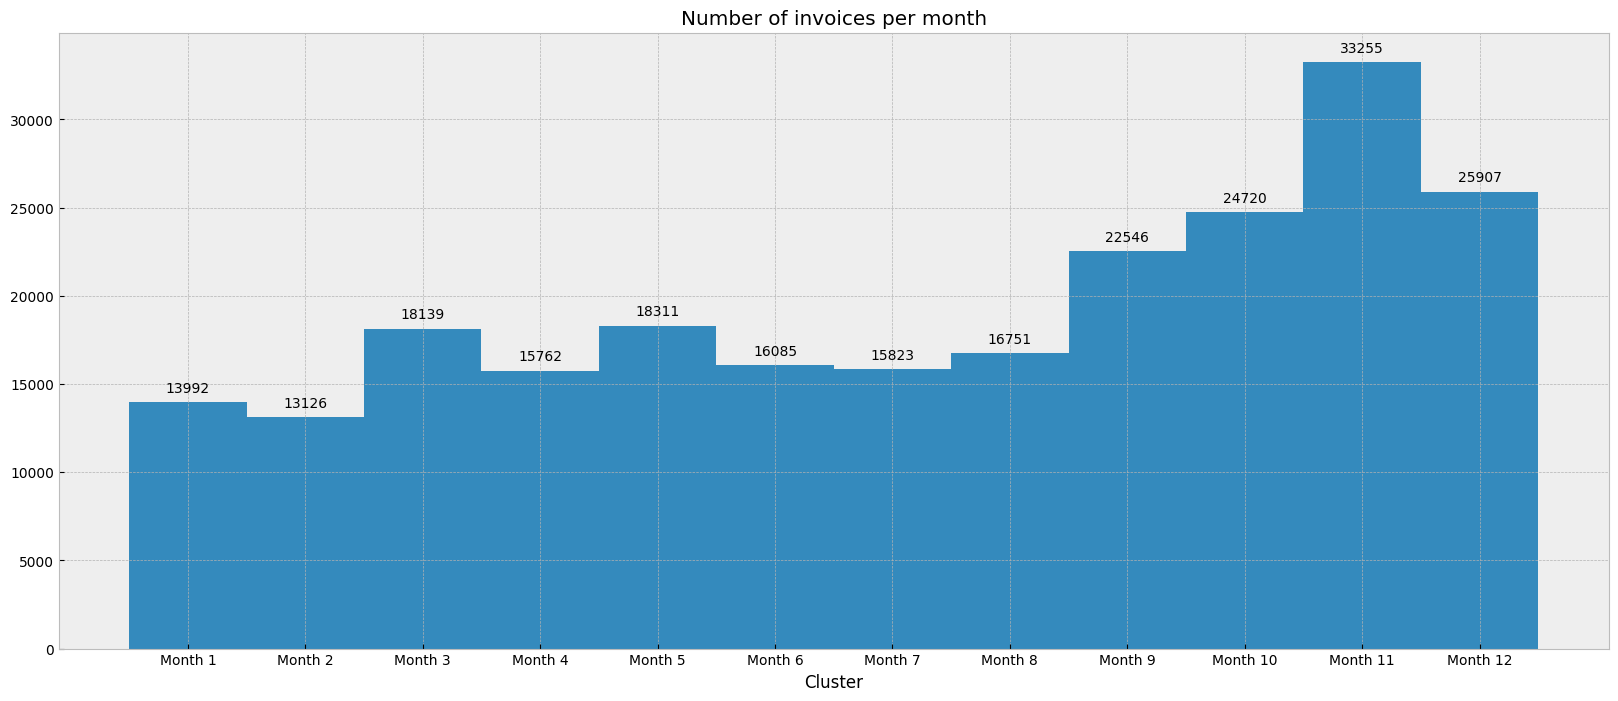

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)
    

In [ ]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    1100
2011.0     423
Name: Year, dtype: int64

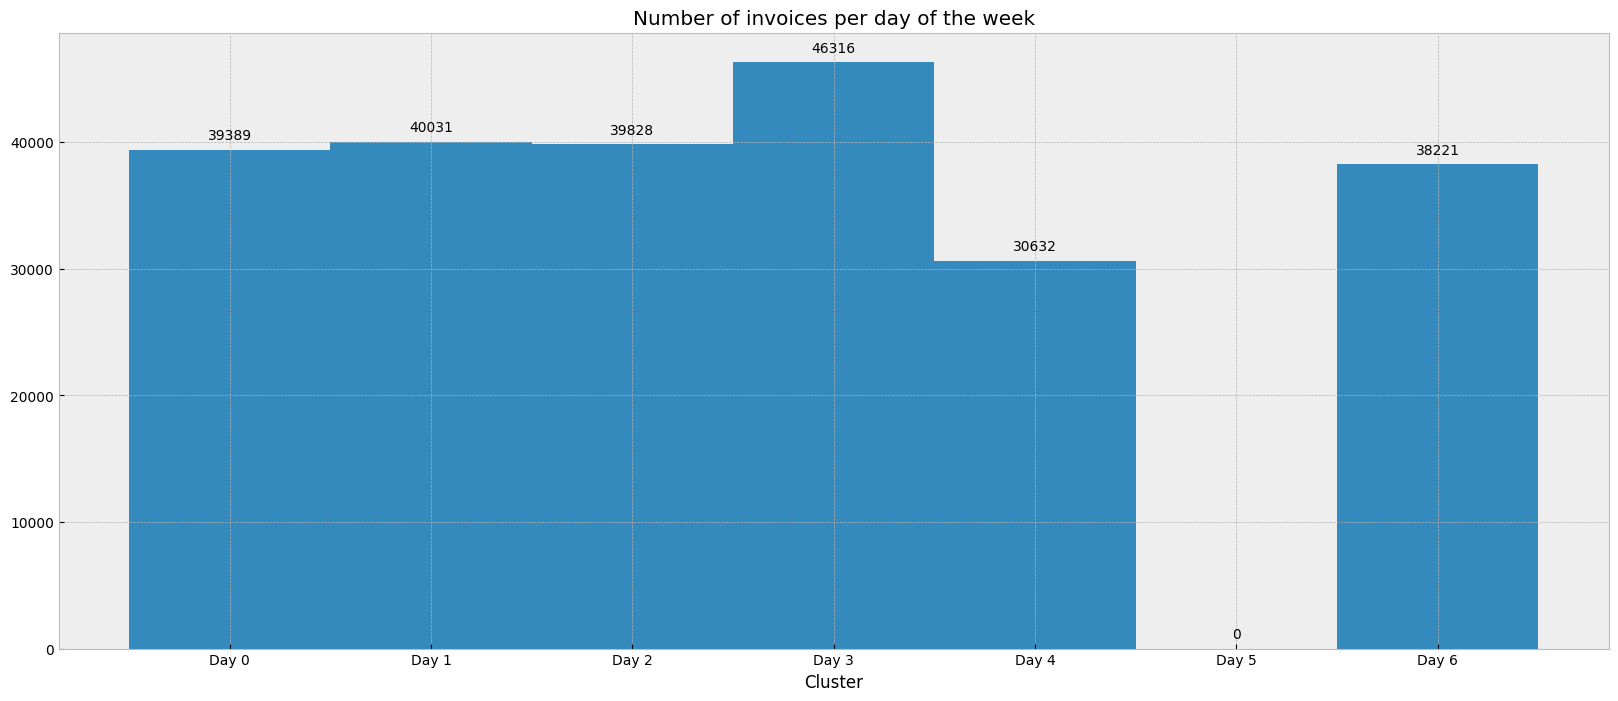

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [ ]:
cluster0['Day'].nunique()

31

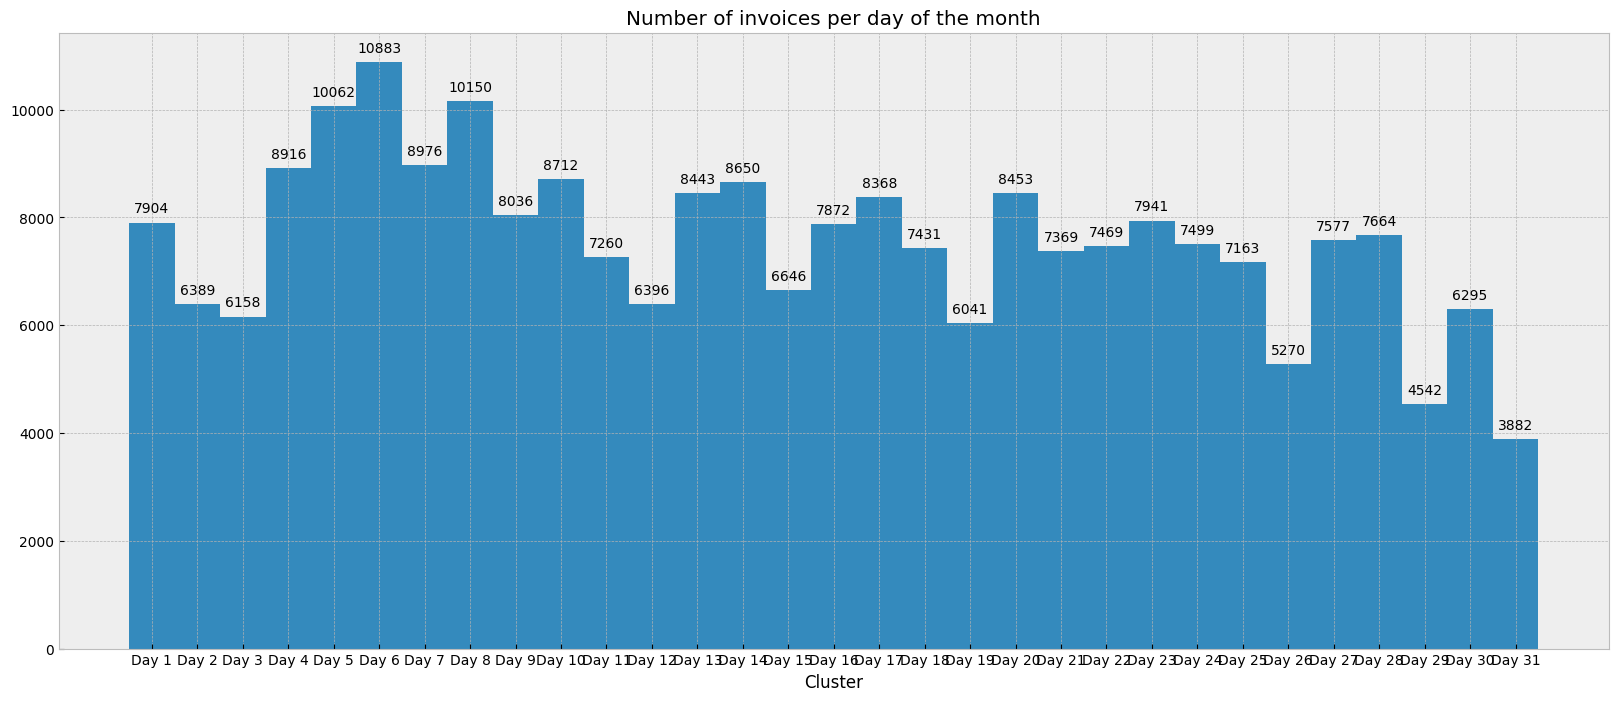

In [ ]:

plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [ ]:
cluster0['Hour'].nunique()


14

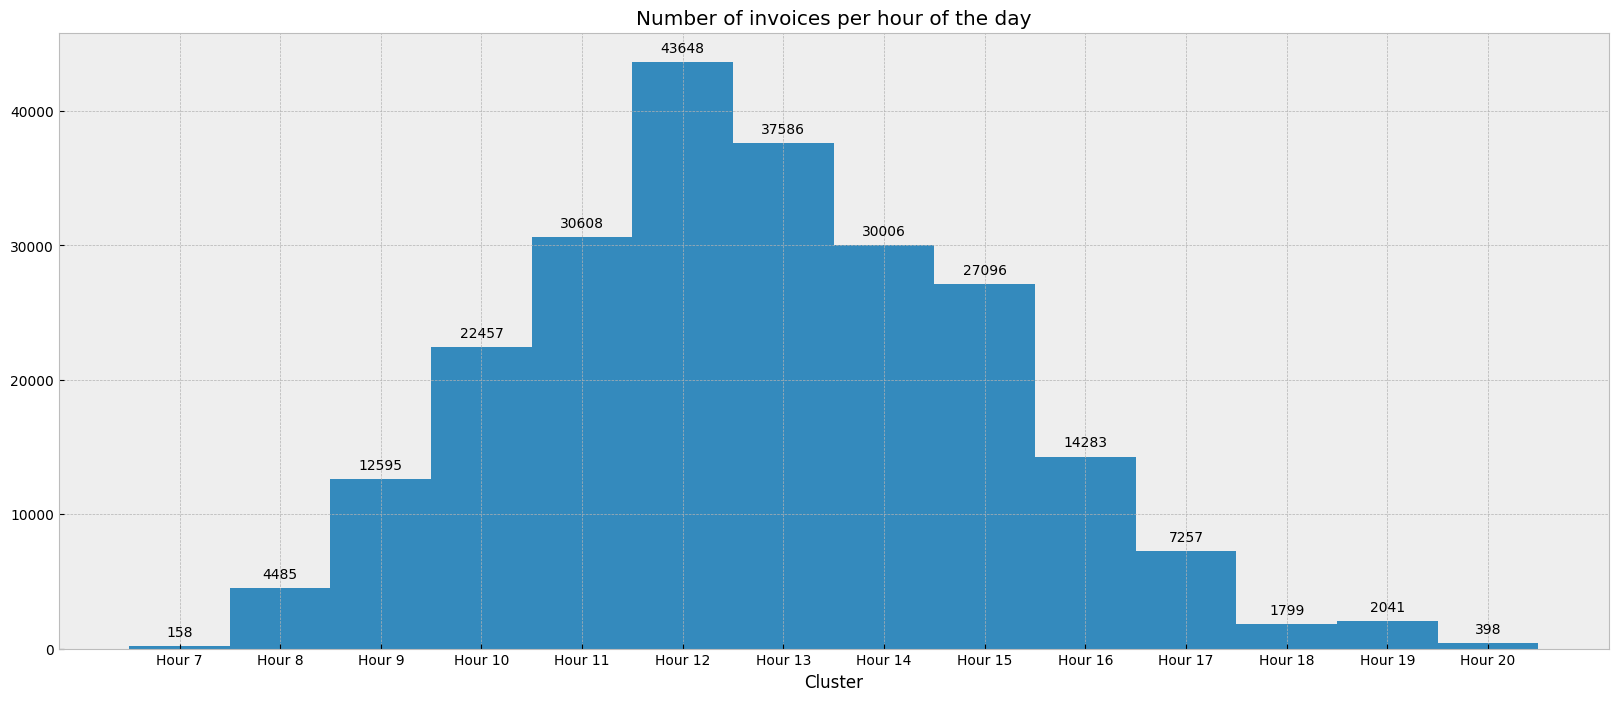

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)
